In [1]:
# import packages 
import torch 
import torch.nn as nn 
import torch.nn.functional as F 
from torch.utils.data import DataLoader 
import torch.optim as optim

import torchvision.datasets as datasets 
import torchvision.transforms as transforms
from torchvision.utils import make_grid 

import matplotlib.pyplot as plt 
import numpy as np 
from scipy.signal import savgol_filter

from six.moves import xrange 

import umap 
from tqdm import tqdm


In [2]:
# configuration 

if torch.cuda.is_available():
    device = torch.device("cuda")
    print("Using CUDA as device")
else:
    # Check that MPS is available
    if not torch.backends.mps.is_available():
        if not torch.backends.mps.is_built():
            print("MPS not available because the current PyTorch install was not "
                  "built with MPS enabled.")
        else:
            print("MPS not available because the current MacOS version is not 12.3+ "
                  "and/or you do not have an MPS-enabled device on this machine.")
        device = torch.device("cpu")
        print("Using CPU as device")
    else:
        device = torch.device("mps")
        print("Using MPS as device")
    
torch.set_default_device(device)

Using MPS as device


In [3]:
# load data 
data_transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (1.0, 1.0, 1.0))
])

train_data = datasets.CIFAR10(root="data", train=True, download=True, transform=data_transform)
data_variance = np.var(train_data.data / 255.0)

test_data = datasets.CIFAR10(root="data", train=False, download=True, transform=data_transform)

Files already downloaded and verified
Files already downloaded and verified


In [4]:
# make a Vector Quantizer Layer 

class VectorQuantizer(nn.Module):
    def __init__(self, num_embeddings, embedding_dim, commitment_cost):
        super(VectorQuantizer, self).__init__()
        self.embedding_dim = embedding_dim
        self.num_embeddings = num_embeddings

        self.embeddings = nn.Embedding(self.num_embeddings, self.embedding_dim)
        self.embeddings.weight.data.uniform_(-1/self.num_embeddings, 1/self.num_embeddings)
        self.commitment_cost = commitment_cost


    def forward(self, inputs):
        # convert inputs from BCHW -> BHWC 
        inputs = inputs.permute(0, 2, 3, 1).contiguous() 
        input_shape = inputs.shape

        # Flatten the input 
        flat_inputs = inputs.view(-1, self.embedding_dim)

        # calculate the distance between input and all the embeddings 
        distances = (torch.sum(flat_inputs**2, dim=1, keepdim=True) 
                     + torch.sum(self.embeddings.weight **2, dim=1)
                     - 2 * torch.matmul(flat_inputs, self.embeddings.weight.t()))

        # get embedding vectors 
        embedding_indices = torch.argmin(distances, dim=1).unsqueeze(1)
        embeddings = torch.zeros(embedding_indices.shape[0], self.num_embeddings, device=device)
        embeddings.scatter_(1, embedding_indices, 1)

        # quantize and unflatten 
        quantized = torch.matmul(embeddings, self.embeddings.weight).view(input_shape)

        # loss 
        e_latent_loss = F.mse_loss(quantized.detach(), inputs)
        q_latent_loss = F.mse_loss(quantized, inputs.detach())
        loss = q_latent_loss + self.commitment_cost * e_latent_loss

        # reconstruction loss will be added later, because we cannot calculate without decoder
        
        quantized = inputs + (quantized - inputs).detach()
        avg_probs = torch.mean(embeddings, dim=0)
        perplexity = torch.exp(-torch.sum(avg_probs * torch.log(avg_probs + 1e-10)))

        return loss, quantized.permute(0, 3, 1, 2).contiguous(), perplexity, embeddings        

In [5]:
# define residual block that is going to be used in encoder and decoder 
class ResCNNBlock(nn.Module): 
    def __init__(self, in_channels):
        super(ResCNNBlock, self).__init__()
        self._block = nn.Sequential(
            nn.Conv2d(in_channels = in_channels, 
                      out_channels= in_channels, 
                      kernel_size = 3, 
                      stride = 1, 
                    padding = 1, 
                    bias = False),
            nn.ReLU(True)
        )
    def forward(self, x): 
        return x + self._block(x)

In [6]:
class Encoder(nn.Module): 
    def __init__(self, in_channels, num_hiddens):
        super(Encoder, self).__init__()
        self.norm1 = nn.BatchNorm2d(in_channels)
        self.conv1 = nn.Conv2d(in_channels=in_channels, out_channels=num_hiddens//2, kernel_size=4, stride=2, padding=1)
        self.norm2 = nn.BatchNorm2d(num_hiddens // 2)
        self.conv2 = nn.Conv2d(in_channels=num_hiddens//2, out_channels=num_hiddens, kernel_size=4, stride=2, padding=1)
        self.norm3 = nn.BatchNorm2d(num_hiddens)
        self.res1 = ResCNNBlock(num_hiddens)
        self.norm4 = nn.BatchNorm2d(num_hiddens)
        self.res2 = ResCNNBlock(num_hiddens)
        self.norm5 = nn.BatchNorm2d(num_hiddens)
        self.res3 = ResCNNBlock(num_hiddens)
        self.norm6 = nn.BatchNorm2d(num_hiddens)
        self.res4 = ResCNNBlock(num_hiddens)
        self.norm7 = nn.BatchNorm2d(num_hiddens)

    def forward(self, inputs):
        x = self.norm1(inputs)
        x = self.conv1(x)
        x = F.relu(x)
        x = self.norm2(x)

        x = self.conv2(x)
        x = F.relu(x)
        x = self.norm3(x)

        x = self.res1(x)
        x = self.norm4(x)
        x = self.res2(x)
        x = self.norm5(x)
        x = self.res3(x)
        x = self.norm6(x)
        x = self.res4(x)
        x = self.norm7(x)
        return x 

In [7]:
class Decoder(nn.Module):
    def __init__(self, in_channels, num_hiddens):
        super(Decoder, self).__init__()

        self.norm1 = nn.BatchNorm2d(in_channels)

        self.conv1 = nn.Conv2d(in_channels=in_channels,
                                 out_channels=num_hiddens,
                                 kernel_size=3, 
                                 stride=1, padding=1)
        self.norm2 = nn.BatchNorm2d(num_hiddens)

        self.res1 = ResCNNBlock(num_hiddens)
        self.norm3 = nn.BatchNorm2d(num_hiddens)
        self.res2 = ResCNNBlock(num_hiddens)
        self.norm4 = nn.BatchNorm2d(num_hiddens)
        self.res3 = ResCNNBlock(num_hiddens)
        self.norm5 = nn.BatchNorm2d(num_hiddens)

        self.conv_trans1 = nn.ConvTranspose2d(in_channels=num_hiddens, out_channels=num_hiddens //2, kernel_size=4, stride=2, padding=1)
        self.norm6 = nn.BatchNorm2d(num_hiddens // 2)
        self.conv_trans2 = nn.ConvTranspose2d(in_channels=num_hiddens//2, out_channels=3, kernel_size=4, stride=2, padding=1)

    def forward(self, inputs):
        x = self.norm1(inputs)
        x = self.conv1(x)
        x = F.relu(x) 
        x = self.norm2(x)
        
        x = self.res1(x)
        x = self.norm3(x)
        x = self.res2(x)
        x = self.norm4(x)
        x = self.res3(x)
        x = self.norm5(x)

        x = self.conv_trans1(x)
        x = F.relu(x) 
        x = self.norm6(x)
        x = self.conv_trans2(x)
        
        return x 
        

In [8]:
# define train configurations 
batch_size = 256 
epochs = 100
num_hiddens = 128 
num_residual_hiddens = 32 

embedding_dims = 64 
num_embeddings = 512 

commitment_cost = 0.25 

init_lr = 1e-3

In [24]:
# define data loaders 
train_loader = DataLoader(train_data, batch_size=batch_size, shuffle=True, pin_memory=True, generator= torch.Generator(device=device))
test_loader = DataLoader(test_data, batch_size=32, shuffle=False, pin_memory=True, generator= torch.Generator(device=device))

In [10]:
# Define a model to train 
class Model(nn.Module): 
    def __init__(self,in_channels, num_hiddens, num_embeddings, embedding_dims, commitment_cost): 
        super(Model, self).__init__()

        self.encoder = Encoder(in_channels, num_hiddens)
        self.pre_vq_conv = nn.Conv2d(in_channels=num_hiddens, out_channels=embedding_dims, kernel_size=1, stride=1)

        self.vq_vae = VectorQuantizer(num_embeddings, embedding_dims, commitment_cost)

        self.decoder = Decoder(embedding_dims, num_hiddens)

    def forward(self, x): 
        z = self.encoder(x) 
        z = self.pre_vq_conv(z) 

        loss, quantized, perplexity, _ = self.vq_vae(z)

        x_recon = self.decoder(quantized)

        return loss, x_recon, perplexity

In [11]:
model = Model(3, num_hiddens, num_embeddings, embedding_dims, commitment_cost)

# load model if possible

In [12]:
optimizer = optim.Adam(model.parameters(), lr=init_lr)

In [13]:
global_recon_errs = [] 
global_perplexities = []

# define a function that trains one epoch 
def train_epoch(epoch_idx, tb_writer): 
    epoch_recon_errs = [] 
    epoch_perplexities = [] 

    for batch_idx, (data, _) in enumerate(train_loader): 
        x = data.to(device)

        optimizer.zero_grad()

        vq_loss, data_recon, perplexity = model(x)
        recon_err = F.mse_loss(data_recon, x) / data_variance

        loss = recon_err + vq_loss 

        loss.backward()
        optimizer.step()

        epoch_recon_errs.append(recon_err.item())
        epoch_perplexities.append(perplexity.item())
        
        global_recon_errs.append(recon_err.item())
        global_perplexities.append(perplexity.item())
        
    print(f'EPOCH {epoch_idx}: ')
    print(f'recon_err: {np.mean(epoch_recon_errs)}')
    print(f'perlexity: {np.mean(epoch_perplexities)}')
    print()
    return loss.item()

In [14]:
# Real training happens at this cell 
from datetime import datetime
from torch.utils.tensorboard import SummaryWriter

timestamp = datetime.now().strftime('%Y%m%d_%H%M%S')
writer = SummaryWriter('runs/fashion_trainer_{}'.format(timestamp))

best_vloss = 1_000_000

for epoch in range(epochs):
    model.train(True)

    train_loss = train_epoch(epoch + 1, writer)

    model.eval()

    running_vloss = 0.0
    with torch.no_grad():
        for batch_idx, (x, _) in enumerate(tqdm(test_loader)):
            x = x.to(device)
            loss, _, _ = model(x)

            running_vloss += loss.item()
    avg_vloss = running_vloss / (batch_idx + 1) 

    print(f'Loss train {train_loss} valid {avg_vloss}')

    if avg_vloss < best_vloss:
        best_vloss = avg_vloss 
        model_path = f'models/model_{timestamp}_{epoch}' 
        torch.save(model.state_dict(), model_path)            

EPOCH 1: 
recon_err: 0.9570645977343831
perlexity: 15.949801785605294



100%|███████████████████████████████████████████| 40/40 [00:02<00:00, 15.72it/s]


Loss train 1.5041604042053223 valid 1.0776935249567032
EPOCH 2: 
recon_err: 0.32045506153787884
perlexity: 9.774149894714355



100%|███████████████████████████████████████████| 40/40 [00:02<00:00, 16.27it/s]


Loss train 1.1569398641586304 valid 0.7867200389504433
EPOCH 3: 
recon_err: 0.2911154784414233
perlexity: 9.948869213765981



100%|███████████████████████████████████████████| 40/40 [00:02<00:00, 16.24it/s]


Loss train 0.9018117785453796 valid 0.49409345611929895
EPOCH 4: 
recon_err: 0.3351536817392524
perlexity: 10.335361329876648



100%|███████████████████████████████████████████| 40/40 [00:02<00:00, 16.18it/s]


Loss train 0.8348751068115234 valid 0.6427596554160118
EPOCH 5: 
recon_err: 0.26724611488836153
perlexity: 11.889297100962425



100%|███████████████████████████████████████████| 40/40 [00:02<00:00, 16.21it/s]


Loss train 0.6656333208084106 valid 0.46177504435181616
EPOCH 6: 
recon_err: 0.24289086476272467
perlexity: 13.524444336793861



100%|███████████████████████████████████████████| 40/40 [00:02<00:00, 16.15it/s]


Loss train 0.6201267242431641 valid 0.39501301050186155
EPOCH 7: 
recon_err: 0.22564176082306978
perlexity: 15.703975735878458



100%|███████████████████████████████████████████| 40/40 [00:02<00:00, 16.19it/s]


Loss train 0.5808461308479309 valid 0.335800152271986
EPOCH 8: 
recon_err: 0.21279087700710006
perlexity: 17.09585679307276



100%|███████████████████████████████████████████| 40/40 [00:02<00:00, 16.17it/s]


Loss train 0.5338718891143799 valid 0.30711665824055673
EPOCH 9: 
recon_err: 0.20373666712215968
perlexity: 17.940878654012874



100%|███████████████████████████████████████████| 40/40 [00:02<00:00, 16.16it/s]


Loss train 0.478498250246048 valid 0.28282019942998887
EPOCH 10: 
recon_err: 0.19400449941048817
perlexity: 19.12622513089861



100%|███████████████████████████████████████████| 40/40 [00:02<00:00, 16.18it/s]


Loss train 0.4685409367084503 valid 0.27049124911427497
EPOCH 11: 
recon_err: 0.1870599771488686
perlexity: 20.206524430489054



100%|███████████████████████████████████████████| 40/40 [00:02<00:00, 16.18it/s]


Loss train 0.44394415616989136 valid 0.251292672380805
EPOCH 12: 
recon_err: 0.17768078320184533
perlexity: 21.15639622357427



100%|███████████████████████████████████████████| 40/40 [00:02<00:00, 16.18it/s]


Loss train 0.4186055362224579 valid 0.24224801249802114
EPOCH 13: 
recon_err: 0.17110526204413298
perlexity: 22.222815591461803



100%|███████████████████████████████████████████| 40/40 [00:02<00:00, 16.15it/s]


Loss train 0.39890581369400024 valid 0.22806486301124096
EPOCH 14: 
recon_err: 0.1647025259325699
perlexity: 23.64631972020986



100%|███████████████████████████████████████████| 40/40 [00:02<00:00, 16.18it/s]


Loss train 0.36350017786026 valid 0.22070851176977158
EPOCH 15: 
recon_err: 0.15758774330725475
perlexity: 24.775691810919312



100%|███████████████████████████████████████████| 40/40 [00:02<00:00, 16.18it/s]


Loss train 0.3729883134365082 valid 0.21381410919129848
EPOCH 16: 
recon_err: 0.14933755841790414
perlexity: 25.926562153563207



100%|███████████████████████████████████████████| 40/40 [00:02<00:00, 16.09it/s]


Loss train 0.3611973524093628 valid 0.20741750597953795
EPOCH 17: 
recon_err: 0.14380988068118386
perlexity: 27.178803132504832



100%|███████████████████████████████████████████| 40/40 [00:02<00:00, 16.16it/s]


Loss train 0.3281002640724182 valid 0.2017235927283764
EPOCH 18: 
recon_err: 0.13929607954864598
perlexity: 28.706766907049683



100%|███████████████████████████████████████████| 40/40 [00:02<00:00, 16.18it/s]


Loss train 0.32331404089927673 valid 0.19333783611655236
EPOCH 19: 
recon_err: 0.13362210354178536
perlexity: 30.166267171198008



100%|███████████████████████████████████████████| 40/40 [00:02<00:00, 16.09it/s]


Loss train 0.33236104249954224 valid 0.18788788542151452
EPOCH 20: 
recon_err: 0.12997088174582744
perlexity: 31.8560192730962



100%|███████████████████████████████████████████| 40/40 [00:02<00:00, 16.17it/s]


Loss train 0.29949796199798584 valid 0.1843010950833559
EPOCH 21: 
recon_err: 0.1256687057641696
perlexity: 33.32575521663744



100%|███████████████████████████████████████████| 40/40 [00:02<00:00, 16.18it/s]


Loss train 0.29398858547210693 valid 0.1762712210416794
EPOCH 22: 
recon_err: 0.12194099429310584
perlexity: 34.33875825453778



100%|███████████████████████████████████████████| 40/40 [00:02<00:00, 16.11it/s]


Loss train 0.3424675762653351 valid 0.1727560330182314
EPOCH 23: 
recon_err: 0.11909158212341825
perlexity: 35.60735319098648



100%|███████████████████████████████████████████| 40/40 [00:02<00:00, 16.19it/s]


Loss train 0.28222978115081787 valid 0.1696486532688141
EPOCH 24: 
recon_err: 0.11574148504557658
perlexity: 36.861282737887635



100%|███████████████████████████████████████████| 40/40 [00:02<00:00, 16.18it/s]


Loss train 0.2822743356227875 valid 0.1638423938304186
EPOCH 25: 
recon_err: 0.11367775389582527
perlexity: 37.789602902470804



100%|███████████████████████████████████████████| 40/40 [00:02<00:00, 16.09it/s]


Loss train 0.27117839455604553 valid 0.160641548037529
EPOCH 26: 
recon_err: 0.11167458277575824
perlexity: 39.78649252288196



100%|███████████████████████████████████████████| 40/40 [00:02<00:00, 16.18it/s]


Loss train 0.2557409703731537 valid 0.15481937676668167
EPOCH 27: 
recon_err: 0.10956195498607596
perlexity: 41.595417956916656



100%|███████████████████████████████████████████| 40/40 [00:02<00:00, 16.15it/s]


Loss train 0.2503181993961334 valid 0.1499291431158781
EPOCH 28: 
recon_err: 0.10698326323561523
perlexity: 43.068072883450256



100%|███████████████████████████████████████████| 40/40 [00:02<00:00, 16.19it/s]


Loss train 0.2407568395137787 valid 0.14543890096247197
EPOCH 29: 
recon_err: 0.10441824216015484
perlexity: 43.677078830952546



100%|███████████████████████████████████████████| 40/40 [00:02<00:00, 16.19it/s]


Loss train 0.2512369453907013 valid 0.14425100460648538
EPOCH 30: 
recon_err: 0.10309416728512365
perlexity: 45.07125042895881



100%|███████████████████████████████████████████| 40/40 [00:02<00:00, 16.18it/s]


Loss train 0.24612215161323547 valid 0.13946822993457317
EPOCH 31: 
recon_err: 0.10047016433459155
perlexity: 46.73307021783323



100%|███████████████████████████████████████████| 40/40 [00:02<00:00, 16.16it/s]


Loss train 0.24063920974731445 valid 0.1367992043495178
EPOCH 32: 
recon_err: 0.09913172975790743
perlexity: 47.652195229822276



100%|███████████████████████████████████████████| 40/40 [00:02<00:00, 16.17it/s]


Loss train 0.24140658974647522 valid 0.13879043459892274
EPOCH 33: 
recon_err: 0.09763512885844221
perlexity: 49.4329928573297



100%|███████████████████████████████████████████| 40/40 [00:02<00:00, 16.16it/s]


Loss train 0.25283706188201904 valid 0.1391359906643629
EPOCH 34: 
recon_err: 0.09665713398432245
perlexity: 51.28025438347641



100%|███████████████████████████████████████████| 40/40 [00:02<00:00, 16.14it/s]


Loss train 0.2463037669658661 valid 0.14296649992465973
EPOCH 35: 
recon_err: 0.09545622625369199
perlexity: 53.09502681420774



100%|███████████████████████████████████████████| 40/40 [00:02<00:00, 16.15it/s]


Loss train 0.24627995491027832 valid 0.14348942562937736
EPOCH 36: 
recon_err: 0.09358673941876207
perlexity: 55.33501352582659



100%|███████████████████████████████████████████| 40/40 [00:02<00:00, 16.16it/s]


Loss train 0.2407202273607254 valid 0.14814720302820206
EPOCH 37: 
recon_err: 0.09271045644976655
perlexity: 56.97356951966577



100%|███████████████████████████████████████████| 40/40 [00:02<00:00, 16.16it/s]


Loss train 0.2364889681339264 valid 0.14944502003490925
EPOCH 38: 
recon_err: 0.09157627798160728
perlexity: 58.69794670416384



100%|███████████████████████████████████████████| 40/40 [00:02<00:00, 16.15it/s]


Loss train 0.25250717997550964 valid 0.1536162368953228
EPOCH 39: 
recon_err: 0.08948862643874421
perlexity: 59.93532087364975



100%|███████████████████████████████████████████| 40/40 [00:02<00:00, 16.16it/s]


Loss train 0.24802082777023315 valid 0.15617433600127698
EPOCH 40: 
recon_err: 0.08853201522510878
perlexity: 61.04748587705651



100%|███████████████████████████████████████████| 40/40 [00:02<00:00, 16.14it/s]


Loss train 0.24870675802230835 valid 0.15725138783454895
EPOCH 41: 
recon_err: 0.08789082472117579
perlexity: 62.68854686192104



100%|███████████████████████████████████████████| 40/40 [00:02<00:00, 16.15it/s]


Loss train 0.2620182931423187 valid 0.1610947623848915
EPOCH 42: 
recon_err: 0.08621578477323055
perlexity: 63.51846438038106



100%|███████████████████████████████████████████| 40/40 [00:02<00:00, 16.17it/s]


Loss train 0.2573174238204956 valid 0.1604112908244133
EPOCH 43: 
recon_err: 0.0852134351295476
perlexity: 63.90727872264628



100%|███████████████████████████████████████████| 40/40 [00:02<00:00, 16.15it/s]


Loss train 0.25247427821159363 valid 0.16124607287347317
EPOCH 44: 
recon_err: 0.08462846678282533
perlexity: 64.61209201812744



100%|███████████████████████████████████████████| 40/40 [00:02<00:00, 16.20it/s]


Loss train 0.23855754733085632 valid 0.16235595159232616
EPOCH 45: 
recon_err: 0.08403630357007591
perlexity: 65.5487814922722



100%|███████████████████████████████████████████| 40/40 [00:02<00:00, 16.16it/s]


Loss train 0.23849281668663025 valid 0.16353023312985898
EPOCH 46: 
recon_err: 0.08273135292894986
perlexity: 66.51881517682757



100%|███████████████████████████████████████████| 40/40 [00:02<00:00, 16.16it/s]


Loss train 0.23653748631477356 valid 0.1628161661326885
EPOCH 47: 
recon_err: 0.0819957324740838
perlexity: 67.79599380493164



100%|███████████████████████████████████████████| 40/40 [00:02<00:00, 16.15it/s]


Loss train 0.23721462488174438 valid 0.16317676641047002
EPOCH 48: 
recon_err: 0.08140979878300307
perlexity: 68.76101310885683



100%|███████████████████████████████████████████| 40/40 [00:02<00:00, 16.13it/s]


Loss train 0.2517695128917694 valid 0.16281695179641248
EPOCH 49: 
recon_err: 0.08062750466015874
perlexity: 69.76620296556122



100%|███████████████████████████████████████████| 40/40 [00:02<00:00, 16.12it/s]


Loss train 0.22745732963085175 valid 0.16172585673630238
EPOCH 50: 
recon_err: 0.08020934694427617
perlexity: 70.57199338017678



100%|███████████████████████████████████████████| 40/40 [00:02<00:00, 16.15it/s]


Loss train 0.240797758102417 valid 0.15999089144170284
EPOCH 51: 
recon_err: 0.07923782297543117
perlexity: 72.2698312486921



100%|███████████████████████████████████████████| 40/40 [00:02<00:00, 15.92it/s]


Loss train 0.2368609607219696 valid 0.16154365688562394
EPOCH 52: 
recon_err: 0.07900317146309785
perlexity: 73.271301814488



100%|███████████████████████████████████████████| 40/40 [00:02<00:00, 15.87it/s]


Loss train 0.24155950546264648 valid 0.1581739377230406
EPOCH 53: 
recon_err: 0.07869303082020915
perlexity: 74.25740631259218



100%|███████████████████████████████████████████| 40/40 [00:02<00:00, 16.07it/s]


Loss train 0.2265581637620926 valid 0.1597277045249939
EPOCH 54: 
recon_err: 0.07779117666032849
perlexity: 75.2570908604836



100%|███████████████████████████████████████████| 40/40 [00:02<00:00, 16.13it/s]


Loss train 0.23458129167556763 valid 0.15743484832346438
EPOCH 55: 
recon_err: 0.07737127144117745
perlexity: 76.01793075094417



100%|███████████████████████████████████████████| 40/40 [00:02<00:00, 16.15it/s]


Loss train 0.2389255315065384 valid 0.15810634642839433
EPOCH 56: 
recon_err: 0.07716147069420133
perlexity: 76.80944096312231



100%|███████████████████████████████████████████| 40/40 [00:02<00:00, 16.12it/s]


Loss train 0.23616164922714233 valid 0.1573964271694422
EPOCH 57: 
recon_err: 0.07623516011755077
perlexity: 77.71958973942971



100%|███████████████████████████████████████████| 40/40 [00:02<00:00, 16.16it/s]


Loss train 0.23854443430900574 valid 0.15477309077978135
EPOCH 58: 
recon_err: 0.07565874100795814
perlexity: 78.57235410262128



100%|███████████████████████████████████████████| 40/40 [00:02<00:00, 16.13it/s]


Loss train 0.2284613847732544 valid 0.15429099053144454
EPOCH 59: 
recon_err: 0.07570206096433864
perlexity: 79.40230424063546



100%|███████████████████████████████████████████| 40/40 [00:02<00:00, 16.13it/s]


Loss train 0.2363511323928833 valid 0.1550203874707222
EPOCH 60: 
recon_err: 0.07503669020928899
perlexity: 79.53941127232143



100%|███████████████████████████████████████████| 40/40 [00:02<00:00, 16.10it/s]


Loss train 0.2333662211894989 valid 0.1554499313235283
EPOCH 61: 
recon_err: 0.07490452481623815
perlexity: 80.78996440342495



100%|███████████████████████████████████████████| 40/40 [00:02<00:00, 16.17it/s]


Loss train 0.23020842671394348 valid 0.1541931513696909
EPOCH 62: 
recon_err: 0.07468059206647533
perlexity: 81.02999235659229



100%|███████████████████████████████████████████| 40/40 [00:02<00:00, 16.00it/s]


Loss train 0.21737878024578094 valid 0.15611182898283005
EPOCH 63: 
recon_err: 0.07374667079777134
perlexity: 82.42806072624363



100%|███████████████████████████████████████████| 40/40 [00:02<00:00, 16.14it/s]


Loss train 0.24155203998088837 valid 0.1554445967078209
EPOCH 64: 
recon_err: 0.07353500139956572
perlexity: 83.40670943746761



100%|███████████████████████████████████████████| 40/40 [00:02<00:00, 16.06it/s]


Loss train 0.23889854550361633 valid 0.15732915475964546
EPOCH 65: 
recon_err: 0.073373195696242
perlexity: 84.20389257158551



100%|███████████████████████████████████████████| 40/40 [00:02<00:00, 16.13it/s]


Loss train 0.23174618184566498 valid 0.15544423535466195
EPOCH 66: 
recon_err: 0.07263331096239235
perlexity: 84.74345872840102



100%|███████████████████████████████████████████| 40/40 [00:02<00:00, 16.15it/s]


Loss train 0.22748059034347534 valid 0.15732384733855725
EPOCH 67: 
recon_err: 0.07239285004990441
perlexity: 85.63817911731954



100%|███████████████████████████████████████████| 40/40 [00:02<00:00, 16.11it/s]


Loss train 0.2298772633075714 valid 0.15587855726480485
EPOCH 68: 
recon_err: 0.07171327309036742
perlexity: 86.30582011475855



100%|███████████████████████████████████████████| 40/40 [00:02<00:00, 16.13it/s]


Loss train 0.21777035295963287 valid 0.15384714715182782
EPOCH 69: 
recon_err: 0.07195774100872936
perlexity: 87.70565468924386



100%|███████████████████████████████████████████| 40/40 [00:02<00:00, 16.10it/s]


Loss train 0.25319308042526245 valid 0.1538886208087206
EPOCH 70: 
recon_err: 0.07119727917775816
perlexity: 88.64678223279057



100%|███████████████████████████████████████████| 40/40 [00:02<00:00, 16.10it/s]


Loss train 0.24117273092269897 valid 0.1520442120730877
EPOCH 71: 
recon_err: 0.0708370532992543
perlexity: 89.30907759374502



100%|███████████████████████████████████████████| 40/40 [00:02<00:00, 16.11it/s]


Loss train 0.22087222337722778 valid 0.1512833323329687
EPOCH 72: 
recon_err: 0.07082100269593755
perlexity: 89.65240404557208



100%|███████████████████████████████████████████| 40/40 [00:02<00:00, 16.13it/s]


Loss train 0.21291238069534302 valid 0.15350381396710872
EPOCH 73: 
recon_err: 0.07029669990344924
perlexity: 91.27651623317173



100%|███████████████████████████████████████████| 40/40 [00:02<00:00, 16.12it/s]


Loss train 0.24509462714195251 valid 0.15024483762681484
EPOCH 74: 
recon_err: 0.07004216723904318
perlexity: 92.64336352445642



100%|███████████████████████████████████████████| 40/40 [00:02<00:00, 16.11it/s]


Loss train 0.22905173897743225 valid 0.14961879141628742
EPOCH 75: 
recon_err: 0.06999104603060655
perlexity: 93.71796222608917



100%|███████████████████████████████████████████| 40/40 [00:02<00:00, 16.14it/s]


Loss train 0.21494930982589722 valid 0.14819588959217073
EPOCH 76: 
recon_err: 0.06943523800190614
perlexity: 94.57206761107153



100%|███████████████████████████████████████████| 40/40 [00:02<00:00, 16.06it/s]


Loss train 0.2438509166240692 valid 0.14897983334958553
EPOCH 77: 
recon_err: 0.06904770709498197
perlexity: 95.31602587018695



100%|███████████████████████████████████████████| 40/40 [00:02<00:00, 16.09it/s]


Loss train 0.22273829579353333 valid 0.14679191038012504
EPOCH 78: 
recon_err: 0.06897497078289791
perlexity: 95.98395694032007



100%|███████████████████████████████████████████| 40/40 [00:02<00:00, 16.10it/s]


Loss train 0.22687095403671265 valid 0.14647001661360265
EPOCH 79: 
recon_err: 0.06891920736857823
perlexity: 96.85362375998983



100%|███████████████████████████████████████████| 40/40 [00:02<00:00, 16.12it/s]


Loss train 0.2213263213634491 valid 0.1476894747465849
EPOCH 80: 
recon_err: 0.06858407333493233
perlexity: 97.69612456341179



100%|███████████████████████████████████████████| 40/40 [00:02<00:00, 16.14it/s]


Loss train 0.21597576141357422 valid 0.1454237185418606
EPOCH 81: 
recon_err: 0.06817887012599683
perlexity: 97.68534162093182



100%|███████████████████████████████████████████| 40/40 [00:02<00:00, 16.15it/s]


Loss train 0.20602619647979736 valid 0.14590137228369712
EPOCH 82: 
recon_err: 0.06847423092671195
perlexity: 98.53202052992218



100%|███████████████████████████████████████████| 40/40 [00:02<00:00, 16.09it/s]


Loss train 0.2189176082611084 valid 0.14403276294469833
EPOCH 83: 
recon_err: 0.06762591897681051
perlexity: 99.36572234484615



100%|███████████████████████████████████████████| 40/40 [00:02<00:00, 16.12it/s]


Loss train 0.20528048276901245 valid 0.14437482543289662
EPOCH 84: 
recon_err: 0.06772304299686636
perlexity: 99.88107299804688



100%|███████████████████████████████████████████| 40/40 [00:02<00:00, 16.15it/s]


Loss train 0.21803215146064758 valid 0.14349380247294902
EPOCH 85: 
recon_err: 0.0674652472632576
perlexity: 100.19258090427944



100%|███████████████████████████████████████████| 40/40 [00:02<00:00, 16.10it/s]


Loss train 0.21272101998329163 valid 0.14378351606428624
EPOCH 86: 
recon_err: 0.06762526762120578
perlexity: 100.90657821966677



100%|███████████████████████████████████████████| 40/40 [00:02<00:00, 16.10it/s]


Loss train 0.21309006214141846 valid 0.14082944206893444
EPOCH 87: 
recon_err: 0.06760564927315833
perlexity: 100.80658095223563



100%|███████████████████████████████████████████| 40/40 [00:02<00:00, 16.03it/s]


Loss train 0.21486656367778778 valid 0.1441806137561798
EPOCH 88: 
recon_err: 0.06705140375665256
perlexity: 100.64408376265546



100%|███████████████████████████████████████████| 40/40 [00:02<00:00, 16.13it/s]


Loss train 0.21450281143188477 valid 0.14138443619012833
EPOCH 89: 
recon_err: 0.06692652153421422
perlexity: 100.50304459552376



100%|███████████████████████████████████████████| 40/40 [00:02<00:00, 15.88it/s]


Loss train 0.20973366498947144 valid 0.13918411545455456
EPOCH 90: 
recon_err: 0.06657152145872919
perlexity: 100.77317564828056



100%|███████████████████████████████████████████| 40/40 [00:02<00:00, 15.90it/s]


Loss train 0.21171939373016357 valid 0.14286995753645898
EPOCH 91: 
recon_err: 0.06716789508580553
perlexity: 101.55504763856226



100%|███████████████████████████████████████████| 40/40 [00:02<00:00, 15.91it/s]


Loss train 0.23837047815322876 valid 0.14261487647891044
EPOCH 92: 
recon_err: 0.06650943649286518
perlexity: 101.52019788780991



100%|███████████████████████████████████████████| 40/40 [00:02<00:00, 15.91it/s]


Loss train 0.20365425944328308 valid 0.14579509682953357
EPOCH 93: 
recon_err: 0.06631812094045537
perlexity: 102.23041526638731



100%|███████████████████████████████████████████| 40/40 [00:02<00:00, 15.92it/s]


Loss train 0.2085973620414734 valid 0.14052626490592957
EPOCH 94: 
recon_err: 0.06651766142066644
perlexity: 102.2841986052844



100%|███████████████████████████████████████████| 40/40 [00:02<00:00, 15.88it/s]


Loss train 0.22482070326805115 valid 0.14040575474500655
EPOCH 95: 
recon_err: 0.06586159170814315
perlexity: 102.87964283690161



100%|███████████████████████████████████████████| 40/40 [00:02<00:00, 15.92it/s]


Loss train 0.19880282878875732 valid 0.14145451188087463
EPOCH 96: 
recon_err: 0.0659227320848375
perlexity: 103.2608028723269



100%|███████████████████████████████████████████| 40/40 [00:02<00:00, 15.91it/s]


Loss train 0.2041151076555252 valid 0.14131585657596588
EPOCH 97: 
recon_err: 0.0659954388796979
perlexity: 103.14615514327069



100%|███████████████████████████████████████████| 40/40 [00:02<00:00, 15.88it/s]


Loss train 0.215729221701622 valid 0.14095633886754513
EPOCH 98: 
recon_err: 0.06589307656929809
perlexity: 104.01108733975157



100%|███████████████████████████████████████████| 40/40 [00:02<00:00, 15.65it/s]


Loss train 0.2187214344739914 valid 0.13665806837379932
EPOCH 99: 
recon_err: 0.06545800459096018
perlexity: 103.96788328521106



100%|███████████████████████████████████████████| 40/40 [00:02<00:00, 15.88it/s]


Loss train 0.216081440448761 valid 0.1405224312096834
EPOCH 100: 
recon_err: 0.06519342624411291
perlexity: 103.92003530385543



100%|███████████████████████████████████████████| 40/40 [00:02<00:00, 15.90it/s]

Loss train 0.20447757840156555 valid 0.13755180798470973


Text(0.5, 0, 'iteration')

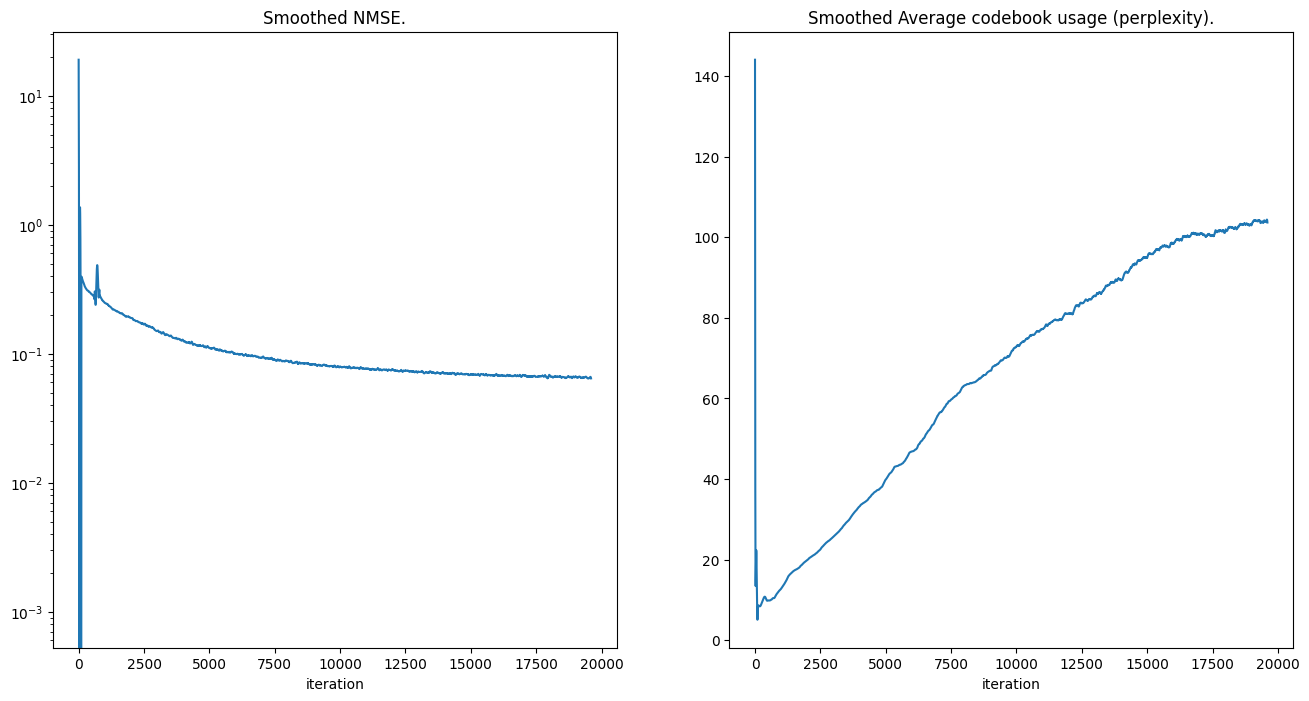

In [15]:
# show the recon_loss and perplexity plot 
train_recon_err_smooth = savgol_filter(global_recon_errs, 201, 7)
train_perplexity_smooth = savgol_filter(global_perplexities, 201, 7)

f = plt.figure(figsize=(16,8))
ax = f.add_subplot(1,2,1)
ax.plot(train_recon_err_smooth)
ax.set_yscale('log')
ax.set_title('Smoothed NMSE.')
ax.set_xlabel('iteration')

ax = f.add_subplot(1,2,2)
ax.plot(train_perplexity_smooth)
ax.set_title('Smoothed Average codebook usage (perplexity).')
ax.set_xlabel('iteration')

In [16]:
def show(img): 
    npimg = img.numpy()
    fig = plt.imshow(np.transpose(npimg, (1,2,0)), interpolation='nearest')
    fig.axes.get_xaxis().set_visible(False)
    fig.axes.get_yaxis().set_visible(False)

In [25]:
# use VQ-VAE to generate samples from test dataset 
model.eval()

(test_originals, _) = next(iter(test_loader))
test_originals = test_originals.to(device)

_, test_reconstruction, _ = model(test_originals)

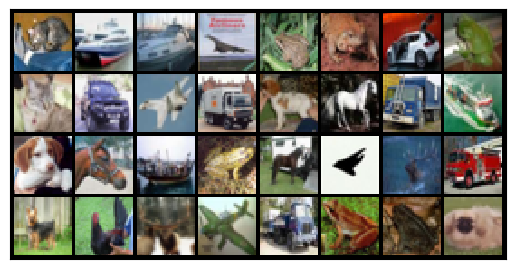

In [26]:
show(make_grid(test_originals.cpu()+0.5))

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.05158043..1.5056666].


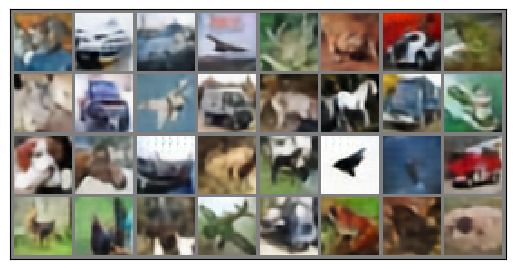

In [27]:
show(make_grid(test_reconstruction.cpu().data)+0.5,)